In [29]:
from active_learning.learner.standard import Learner, get_classifier
from active_learning.weak_supervision.SelfTraining import SelfTraining
import argparse
import numpy as np
import copy
import pandas as pd
import math
import random
from sklearn.metrics import accuracy_score, f1_score
from timeit import default_timer as timer
from typing import List, Dict
from active_learning.config import get_active_config
from active_learning.dataStorage import DataStorage
from active_learning.datasets import load_synthetic
from active_learning.logger import init_logger
from active_learning.merge_weak_supervision_label_strategies.MajorityVoteLabelMergeStrategy import (
    MajorityVoteLabelMergeStrategy,
)
from collections import Counter

from active_learning.weak_supervision import SyntheticLabelingFunctions
from active_learning.weak_supervision.BaseWeakSupervision import BaseWeakSupervision

import seaborn as sns
import matplotlib.pyplot as plt
#sns.set_theme(style="whitegrid")


font_size = 8

tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "text.usetex": False,
    "font.family": ["Times New Roman", 'sans-serif'],
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": font_size,
    "font.size": font_size,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": font_size,
    "xtick.labelsize": font_size,
    "ytick.labelsize": font_size,
    "xtick.bottom": True,
    "figure.autolayout": True,
}

sns.set_style("whitegrid")
sns.set_context("paper")
plt.rcParams.update(tex_fonts)  # type: ignore


# https://jwalton.info/Embed-Publication-Matplotlib-Latex/
def set_matplotlib_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim


#width = 505.89
width = 1500


df = pd.read_csv("new.csv")
df['AMOUNT_OF_LFS'] = np.ceil(df['AMOUNT_OF_LFS'])
df.iloc[0].to_dict()

{'AMOUNT_OF_LFS': 2.0,
 'DATASET': 'HEART',
 'DATASET_RANDOM_GENERATION_SEED': 28296.0,
 'FRACTION_OF_INITIALLY_LABELLED_SAMPLES': 0.3742707957561203,
 'FRACTION_OF_LASTLY_AL_LABELLED_SAMPLES': 0.3706421470668909,
 'JOB_ID': 75.0,
 'LF_RANDOM_SEED': 238068.0,
 'MERGE_WS_SAMPLES_STRATEGY': 'MajorityVoteLabelMergeStrategy',
 'acc_al_and_al': 0.3708609271523179,
 'acc_al_and_ws_and_al': 0.8874172185430463,
 'acc_initial': 0.3973509933774834,
 'acc_ws': 0.9867549668874172,
 'al_sampling_strategy': 'UncertaintyMaxMargin_no_ws',
 'amount_of_initial_al_samples': 57.0,
 'amount_of_lastly_al_samples': 35.0,
 'class_sep': '?',
 'f1_al_and_al': 0.5410628019323671,
 'f1_al_and_ws_and_al': 0.9403508771929824,
 'f1_initial': 0.5687203791469194,
 'f1_ws': 0.9933333333333334,
 'flip_y': '?',
 'hypercube': '?',
 'n_classes': 2.0,
 'n_clusters_per_class': '?',
 'n_features': 14.0,
 'n_informative': 14.0,
 'n_redundant': 0.0,
 'n_repeated': 0.0,
 'n_samples': 303.0,
 'random_state': 28296.0,
 'scale': '?

Desirable Output: "exps with al_ws_al > ws_al": 
    lf_classifiers_knn:     80% vs 40% (all)
    amount_of_lf_features:  4.5 vs 7.0
    Offene Frage: macht es Sinn den Vergleich gegen ALL zu machen, oder lieber vergleich gegen "not davor"

In [103]:
from tabulate import tabulate


def comparison_table(df, selection):
    print(len(df))
    filtered_df = df[selection]
    not_filtered_df = df[~selection]
    result = [["Amount" ,len(filtered_df), "", len(not_filtered_df), ""]]
    skip_keys = ["DATASET_RANDOM_GENERATION_SEED", "LF_RANDOM_SEED", "random_state", "JOB_ID", ]
    for key in df.keys():
        if key in skip_keys:
            continue
        if df.dtypes[key] == np.float64 or df.dtypes[key] == np.int64:
            selection = filtered_df[key]
            not_selection = not_filtered_df[key]
            average = selection.mean()
            not_average = not_selection.mean()
            error_area = 1.96 * selection.std() / math.sqrt(selection.count())
            not_error_area = (
                1.96 * not_selection.std() / math.sqrt(not_selection.count())
            )
            result.append((key, "{:4.2}".format(average), "±{:4.2%}".format(error_area), "{:4.2}".format(not_average), "±{:4.2%}".format(not_error_area)))

        elif df.dtypes[key] == object:
            average = " | ".join(
                [
                    k + ": " + str(v)
                    for k, v in filtered_df[key].value_counts().nlargest(5).iteritems()
                ]
            )
            not_average = ",".join(
                [
                    k + ": " + str(v)
                    for k, v in not_filtered_df[key]
                    .value_counts()
                    .nlargest(5)
                    .iteritems()
                ]
            )
            result.append((key, average, "", not_average, ""))
        else:
            print(key)
            print(df.dtypes[key])

    return result

    """
    mean = selection.mean()
    error_area = 1.96 * selection.std() / math.sqrt(
            selection.count()
        )
    results.append([key, mean, error_area])
    print(TITLE)
    print("{:>60} {:>6} {:>4}".format("", "Mean", ""))
    for result in results:
        print("{:<50} {:>6.2%} ±{:>4.2%}".format(result[0], float(result[1]), float(result[2])))
    """


result = comparison_table(
    df, df["acc_al_and_ws_and_al"] > df["acc_ws"] 
)
print("Accuracy after AL, WS, AL is greater than after AL and WS")
tabulate(result, tablefmt='html')

56034
Accuracy after AL, WS, AL is greater than after AL and WS


Amount,29935,,26099,
AMOUNT_OF_LFS,4.7,±2.74%,4.8,±3.00%
DATASET,synthetic: 15350 | cifar10: 1506 | flag: 1274 | australian: 1146 | DIABETES: 1065,,"synthetic: 3238,HEART: 1703,FERTILITY: 1686,PLANNING: 1339,abalone: 1331",
FRACTION_OF_INITIALLY_LABELLED_SAMPLES,0.48,±0.31%,0.5,±0.35%
FRACTION_OF_LASTLY_AL_LABELLED_SAMPLES,0.54,±0.31%,0.46,±0.36%
MERGE_WS_SAMPLES_STRATEGY,RandomLabelMergeStrategy: 11205 | MajorityVoteLabelMergeStrategy: 10264 | SnorkelLabelMergeStrategy: 8466,,"MajorityVoteLabelMergeStrategy: 10274,RandomLabelMergeStrategy: 9699,SnorkelLabelMergeStrategy: 6126",
acc_al_and_al,0.6,±0.20%,0.56,±0.33%
acc_al_and_ws_and_al,0.58,±0.20%,0.56,±0.31%
acc_initial,0.58,±0.20%,0.58,±0.32%
acc_ws,0.53,±0.20%,0.59,±0.31%
al_sampling_strategy,Random: 5235 | CoveredByLeastAmountOfLf: 5132 | UncertaintyMaxMargin_no_ws: 5053 | UncertaintyMaxMargin_with_ws: 5053 | GreatestDisagreement: 4878,,"ClassificationIsMostWrong: 4755,GreatestDisagreement: 4461,UncertaintyMaxMargin_no_ws: 4286,UncertaintyMaxMargin_with_ws: 4286,CoveredByLeastAmountOfLf: 4207",


In [107]:
result = comparison_table(
    df, (df["n_repeated"] > 4 )&(df["n_redundant"] >8)
)
print("Accuracy after AL, WS, AL is greater than after AL and WS")
tabulate(result, tablefmt='html')

56034
Accuracy after AL, WS, AL is greater than after AL and WS


Amount,18588,,37446,
AMOUNT_OF_LFS,4.7,±3.44%,4.8,±2.50%
DATASET,synthetic: 18588,,"HABERMAN: 2028,australian: 1974,ILPD: 1914,dwtc: 1896,HEART: 1890",
FRACTION_OF_INITIALLY_LABELLED_SAMPLES,0.5,±0.41%,0.48,±0.28%
FRACTION_OF_LASTLY_AL_LABELLED_SAMPLES,0.5,±0.41%,0.51,±0.29%
MERGE_WS_SAMPLES_STRATEGY,MajorityVoteLabelMergeStrategy: 6972 | RandomLabelMergeStrategy: 6606 | SnorkelLabelMergeStrategy: 5010,,"RandomLabelMergeStrategy: 14298,MajorityVoteLabelMergeStrategy: 13566,SnorkelLabelMergeStrategy: 9582",
acc_al_and_al,0.57,±0.06%,0.59,±0.28%
acc_al_and_ws_and_al,0.53,±0.09%,0.59,±0.27%
acc_initial,0.54,±0.09%,0.6,±0.27%
acc_ws,0.49,±0.09%,0.59,±0.26%
al_sampling_strategy,UncertaintyMaxMargin_no_ws: 3098 | ClassificationIsMostWrong: 3098 | CoveredByLeastAmountOfLf: 3098 | UncertaintyMaxMargin_with_ws: 3098 | Random: 3098,,"UncertaintyMaxMargin_no_ws: 6241,CoveredByLeastAmountOfLf: 6241,UncertaintyMaxMargin_with_ws: 6241,GreatestDisagreement: 6241,ClassificationIsMostWrong: 6241",


<AxesSubplot:>

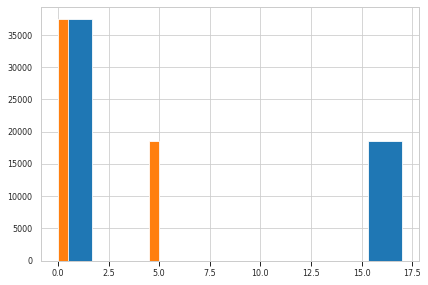

In [109]:
df['n_redundant'].hist()
df['n_repeated'].hist()